In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas
import sklearn

In [3]:
data = pandas.read_csv('./data/james_river_data.txt',
                       comment="#",
                       sep='\t',
                       dtype={"discharge_cfs": int, "flow_rate_ft": float}
                      )
data = data.drop(index=0) # Drop the one time record with metadata under the headers
# data = data.astype({"datetime": 'datetime64[ns, US/Eastern]'})
data['datetime'] = pandas.to_datetime(data['datetime'])
data = data.rename(columns = {"147077_00060": "discharge_cfs", 
                              "147077_00060_cd": "discharge_read_type",
                              "147078_00065": "flow_rate_ft",
                              "147078_00065_cd": "flow_rate_read_type"})
print(f"Before filtering we have {len(data.index)} records")
data = data.dropna()
print(f"After filtering we have {len(data.index)} records")
data = data.convert_dtypes()
data = data.astype({"discharge_cfs": int, "flow_rate_ft": float})
data = data.loc[data['flow_rate_read_type'] == 'A'] # Remove 'P' == predicted values from the future
data = data.loc[data['discharge_read_type'] == 'A'] # Remove 'P' == predicted values from the future

data.head(15)

/Users/brianskarda/Library/Caches/pypoetry/virtualenvs/model-CDSBhTbK-py3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,4,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Before filtering we have 382942 records
After filtering we have 381670 records


,agency_cd,site_no,datetime,tz_cd,discharge_cfs,discharge_read_type,flow_rate_ft,flow_rate_read_type
1,USGS,02037500,2010-07-02 00:00:00,EDT,1120,A,3.57,A
2,USGS,02037500,2010-07-02 00:15:00,EDT,1120,A,3.57,A
3,USGS,02037500,2010-07-02 00:30:00,EDT,1120,A,3.57,A
4,USGS,02037500,2010-07-02 00:45:00,EDT,1120,A,3.57,A
5,USGS,02037500,2010-07-02 01:00:00,EDT,1120,A,3.57,A
6,USGS,02037500,2010-07-02 01:15:00,EDT,1120,A,3.57,A
7,USGS,02037500,2010-07-02 01:30:00,EDT,1120,A,3.57,A
8,USGS,02037500,2010-07-02 01:45:00,EDT,1120,A,3.57,A
9,USGS,02037500,2010-07-02 02:00:00,EDT,1120,A,3.57,A
10,USGS,02037500,2010-07-02 02:15:00,EDT,1120,A,3.57,A


In [4]:
data.dtypes

agency_cd                      string
site_no                        object
datetime               datetime64[ns]
tz_cd                          string
discharge_cfs                   int64
discharge_read_type            string
flow_rate_ft                  float64
flow_rate_read_type            string
dtype: object

In [5]:
from pandas_profiling import ProfileReport

profile = ProfileReport(data, title="James River Data", explorative=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [9]:
profile.to_file("../app/public/james_river_data_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
data["month"] = data["datetime"].dt.month
data["day"] = data["datetime"].dt.day

selected_month_data = data[["month", "flow_rate_ft"]]
selected_month_data.head()

,month,flow_rate_ft
1,7,3.57
2,7,3.57
3,7,3.57
4,7,3.57
5,7,3.57


In [11]:
# Unsupervised Clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4).fit(selected_month_data)

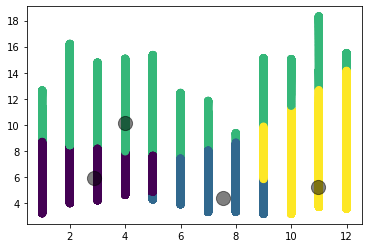

In [12]:
import matplotlib.pyplot as plt

kmeans_predict = kmeans.predict(selected_month_data)
plt.scatter(selected_month_data[["month"]], selected_month_data["flow_rate_ft"], c=kmeans_predict, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [13]:
import numpy
kmeans.predict(numpy.array([12, 4]).reshape(1, -1))


array([3], dtype=int32)

In [14]:
# Supervised Classification

# Flood Categories (in feet)
# Major Flood Stage:	22
# Moderate Flood Stage:	15
# Flood Stage:	12
# Action Stage:	9

data.loc[data["flow_rate_ft"] > 0, "stage"] = 0
data.loc[data["flow_rate_ft"] > 9, "stage"] = 1
data.loc[data["flow_rate_ft"] > 12, "stage"] = 2
data.loc[data["flow_rate_ft"] > 15, "stage"] = 3
data.loc[data["flow_rate_ft"] > 22, "stage"] = 4

supervised_classification_data = data[["month", "day", "stage"]]

from sklearn.model_selection import train_test_split
train_input, test_input, train_output, test_output = train_test_split(supervised_classification_data[["month", "day"]],
                                                                    supervised_classification_data["stage"])

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn_model = knn.fit(train_input, train_output)

knn_score = knn_model.score(test_input, test_output)
print(f"accuracty {knn_score}")

# Plot the training points
#plt.scatter(train_input["month"], ["day"], c=validation_train)
# Plot the testing points
#plt.scatter(input_test[:, 0], input_test[:, 1], c=validation_test, cmap=cm_bright, edgecolors='k', alpha=0.6)

accuracty 0.9165061766489684


In [15]:
# TODO slow
#plt.bar(test_input["month"].astype(str) + "-" + test_input["day"].astype(str), test_output)

accuracy 0.2869547255927122


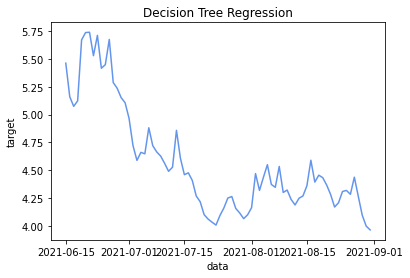

In [16]:
# Supervised Regression
from sklearn.tree import DecisionTreeRegressor

supervised_regression_data = data[["month", "day", "flow_rate_ft"]]

train_input, test_input, train_output, test_output = train_test_split(supervised_regression_data[["month", "day"]],
                                                                      supervised_regression_data["flow_rate_ft"])

dt = DecisionTreeRegressor()
dt_model = dt.fit(train_input, train_output)

dt_score = dt_model.score(test_input, test_output)
print(f"accuracy {dt_score}")

test_dates = pandas.date_range(start='2021-06-15', end='2021-08-31')
test_dates = pandas.DataFrame(test_dates)
test_dates["month"] = test_dates[0].dt.month
test_dates["day"] = test_dates[0].dt.day
test_dates.head()
dt_predictions = dt_model.predict(test_dates[["month", "day"]])

# Plot the results
plt.figure()

plt.plot(test_dates[0], dt_predictions, color="cornflowerblue", label="predictions")
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.show()

In [29]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType

initial_type = [('input', FloatTensorType([None, 2]))]

onx = convert_sklearn(dt_model, initial_types=initial_type, target_opset=13)
with open("../app/public/dt_james.onnx", "wb") as f:
    f.write(onx.SerializeToString())